In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize

In [47]:
train_df = pd.read_csv("../data/cleaned_data/cleaned_data_train.csv")
dev_df = pd.read_csv("../data/cleaned_data/cleaned_data_dev.csv")
test_df = pd.read_csv("../data/cleaned_data/cleaned_data_test.csv")

In [48]:
df = pd.concat([train_df, dev_df, test_df])

In [49]:
def group_sentence(data):
    # Group tokens and labels by sentences
    sentences = []
    labels = []
    sentence_tokens = []
    sentence_labels = []

    for _, row in data.iterrows():
        token = row['token']
        label = row['label']
        
        if token == '.':  # End of a sentence
            sentences.append(sentence_tokens)
            labels.append(sentence_labels)
            sentence_tokens = []
            sentence_labels = []
        else:
            sentence_tokens.append(token)
            sentence_labels.append(label)

    # Add the last sentence if any
    if sentence_tokens:
        sentences.append(sentence_tokens)
        labels.append(sentence_labels)

    return sentences, labels


In [50]:

# Encode tokens and labels
def encode_data(sentences, labels, token2idx, label2idx, max_len):
    encoded_tokens = []
    encoded_labels = []

    for sentence, label_seq in zip(sentences, labels):
        token_ids = [token2idx.get(token, token2idx["<UNK>"]) for token in sentence]
        label_ids = [label2idx[label] for label in label_seq]
        
        # Padding
        token_ids = token_ids[:max_len] + [token2idx["<PAD>"]] * (max_len - len(token_ids))
        label_ids = label_ids[:max_len] + [label2idx["<PAD>"]] * (max_len - len(label_ids))
        
        encoded_tokens.append(token_ids)
        encoded_labels.append(label_ids)

    return torch.tensor(encoded_tokens, dtype=torch.long), torch.tensor(encoded_labels, dtype=torch.long)

In [51]:
# BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out)
        return output

In [53]:
sentences, labels = group_sentence(df)

In [54]:
sentences[0], labels[0]

(['In',
  'this',
  'article',
  'we',
  'discuss',
  'several',
  'metrics',
  'of',
  'coherence',
  'defined',
  'using',
  'centering',
  'theory',
  'and',
  'investigate',
  'the',
  'usefulness',
  'of',
  'such',
  'metrics',
  'for',
  'information',
  'ordering',
  'in',
  'automatic',
  'text',
  'generation'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'O',
  'O',
  'B',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I'])

In [55]:
# Create vocabularies
unique_tokens = set(token for sentence in sentences for token in sentence)
unique_labels = set(label for label_seq in labels for label in label_seq)

In [56]:
token2idx = {token: idx for idx, token in enumerate(unique_tokens, start=2)}
token2idx["<PAD>"] = 0
token2idx["<UNK>"] = 1

In [57]:
label2idx = {label: idx for idx, label in enumerate(unique_labels, start=1)}
label2idx["<PAD>"] = 0

idx2label = {idx: label for label, idx in label2idx.items()}

In [108]:
# Hyperparameters
embedding_dim = 100
hidden_dim = 128
max_len = 50
batch_size = 32
epochs = 20
learning_rate = 0.001

In [109]:

# Encode the data
X, y = encode_data(sentences, labels, token2idx, label2idx, max_len)

In [110]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [113]:
# Model, loss, optimizer
model = BiLSTM_NER(len(token2idx), embedding_dim, hidden_dim, len(label2idx), token2idx["<PAD>"])
criterion = nn.CrossEntropyLoss(ignore_index=label2idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [114]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        
        # Reshape for loss
        outputs = outputs.view(-1, len(label2idx))
        y_batch = y_batch.view(-1)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/20, Loss: 39.5723
Epoch 2/20, Loss: 25.1706
Epoch 3/20, Loss: 19.5579
Epoch 4/20, Loss: 15.6289
Epoch 5/20, Loss: 12.4895
Epoch 6/20, Loss: 9.7788
Epoch 7/20, Loss: 7.1782
Epoch 8/20, Loss: 5.1066
Epoch 9/20, Loss: 3.5174
Epoch 10/20, Loss: 2.3094
Epoch 11/20, Loss: 1.5318
Epoch 12/20, Loss: 1.0692
Epoch 13/20, Loss: 0.7746
Epoch 14/20, Loss: 0.5880
Epoch 15/20, Loss: 0.4205
Epoch 16/20, Loss: 0.3303
Epoch 17/20, Loss: 0.2375
Epoch 18/20, Loss: 0.1922
Epoch 19/20, Loss: 0.1854
Epoch 20/20, Loss: 0.1530


In [115]:
# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions = outputs.argmax(dim=2)
            
            # Ignore PAD tokens
            mask = (y_batch != label2idx["<PAD>"]).view(-1)
            correct += (predictions.view(-1)[mask] == y_batch.view(-1)[mask]).sum().item()
            total += mask.sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

In [116]:
evaluate_model(model, test_loader)

Accuracy: 0.9499


In [127]:
# Saving the model's state dictionary
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# Example usage
save_model(model, "../models/trained_models/bilstm_ner_model.pth")

Model saved to ../models/trained_models/bilstm_ner_model.pth


In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
# Function to evaluate the model and collect predictions and true labels
def evaluate_model_with_metrics(model, dataloader, idx2label, label2idx):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions = outputs.argmax(dim=2)

            for pred, true in zip(predictions, y_batch):
                # Flatten and filter out PAD tokens
                pred = pred.view(-1)
                true = true.view(-1)
                
                mask = true != label2idx["<PAD>"]
                all_predictions.extend(pred[mask].cpu().numpy())
                all_true_labels.extend(true[mask].cpu().numpy())
    
    return all_predictions, all_true_labels

In [118]:
# Get predictions and true labels
predictions, true_labels = evaluate_model_with_metrics(model, test_loader, idx2label, label2idx)

# Filter out <PAD> from the labels
valid_labels = [label for label in label2idx.keys() if label not in ["<PAD>", "O"]]
valid_indices = [label2idx[label] for label in valid_labels]

# Map indices back to labels for valid predictions and true labels
pred_labels = [idx2label[pred] for pred in predictions]
true_labels = [idx2label[true] for true in true_labels]

In [119]:
# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, labels=valid_labels, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           B       0.90      0.86      0.88      1300
           I       0.90      0.89      0.90      1334

   micro avg       0.90      0.88      0.89      2634
   macro avg       0.90      0.88      0.89      2634
weighted avg       0.90      0.88      0.89      2634



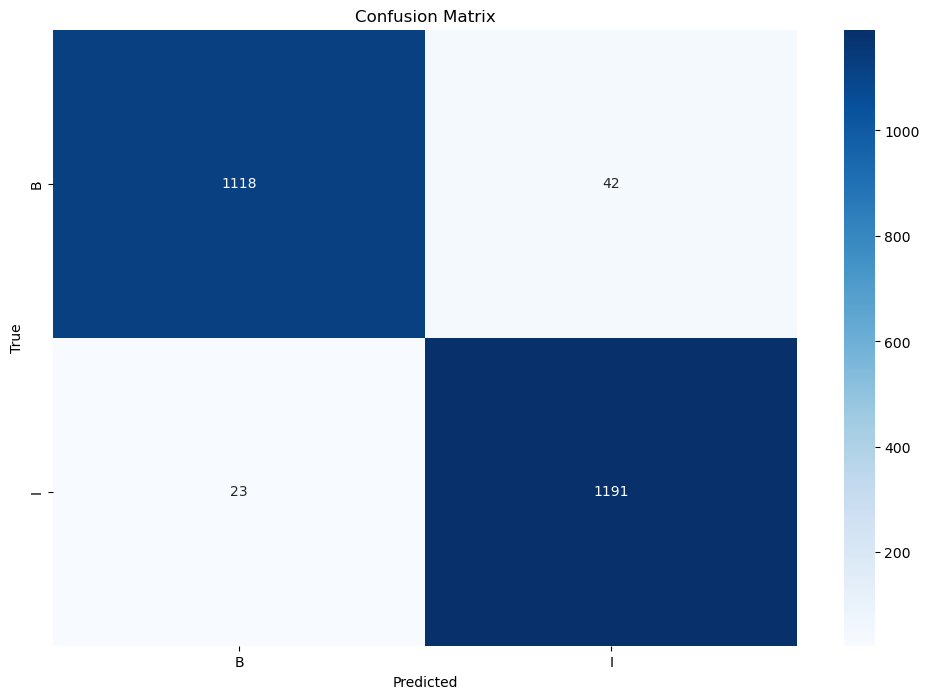

In [120]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=valid_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [89]:
def infer(model, sentence, token2idx, idx2label, max_len):
    """
    Predict NER tags for a single sentence.

    Parameters:
    - model: Trained BiLSTM model
    - sentence: List of tokens (words) in the sentence
    - token2idx: Dictionary mapping tokens to indices
    - idx2label: Dictionary mapping indices to labels
    - max_len: Maximum sequence length

    Returns:
    - List of (token, predicted_label) tuples
    """
    model.eval()
    with torch.no_grad():
        # Encode the sentence
        token_ids = [token2idx.get(token, token2idx["<UNK>"]) for token in sentence]
        token_ids = token_ids[:max_len] + [token2idx["<PAD>"]] * (max_len - len(token_ids))
        
        # Convert to tensor and add batch dimension
        input_tensor = torch.tensor([token_ids], dtype=torch.long)
        
        # Make predictions
        outputs = model(input_tensor)
        predictions = outputs.argmax(dim=2).squeeze(0)
        
        # Map predictions back to labels
        predicted_labels = [idx2label[pred.item()] for pred in predictions[:len(sentence)]]
        
        return list(zip(sentence, predicted_labels))


In [121]:
text = "NLP powers many applications that use language, such as text translation, voice recognition, text summarization, and chatbots."

In [124]:
# Example usage
unseen_sentence = word_tokenize(text)
predictions = infer(model, unseen_sentence, token2idx, idx2label, max_len)

# Print predictions
print("Predictions:")
for token, label in predictions:
    # print(f"{token}: {label}")
    print(tuple((token, label)))

Predictions:
('NLP', 'B')
('powers', 'O')
('many', 'O')
('applications', 'O')
('that', 'O')
('use', 'O')
('language', 'B')
(',', 'O')
('such', 'O')
('as', 'O')
('text', 'B')
('translation', 'I')
(',', 'O')
('voice', 'O')
('recognition', 'B')
(',', 'O')
('text', 'B')
('summarization', 'I')
(',', 'O')
('and', 'O')
('chatbots', 'B')
('.', 'I')


In [125]:
text = "NLP models are computational systems that can process natural language data, such as text or speech, and perform various tasks, such as translation, summarization, sentiment analysis, etc. NLP models are usually based on machine learning or deep learning techniques that learn from large amounts of language data."

In [126]:
# Example usage
unseen_sentence = word_tokenize(text)
predictions = infer(model, unseen_sentence, token2idx, idx2label, max_len)

# Print predictions
print("Predictions:")
for token, label in predictions:
    # print(f"{token}: {label}")
    print(tuple((token, label)))

Predictions:
('NLP', 'B')
('models', 'I')
('are', 'O')
('computational', 'O')
('systems', 'O')
('that', 'O')
('can', 'O')
('process', 'O')
('natural', 'B')
('language', 'I')
('data', 'I')
(',', 'O')
('such', 'O')
('as', 'O')
('text', 'O')
('or', 'O')
('speech', 'O')
(',', 'O')
('and', 'O')
('perform', 'O')
('various', 'O')
('tasks', 'O')
(',', 'O')
('such', 'O')
('as', 'O')
('translation', 'B')
(',', 'O')
('summarization', 'O')
(',', 'O')
('sentiment', 'O')
('analysis', 'O')
(',', 'O')
('etc', 'B')
('.', 'O')
('NLP', 'B')
('models', 'I')
('are', 'O')
('usually', 'O')
('based', 'O')
('on', 'O')
('machine', 'B')
('learning', 'I')
('or', 'O')
('deep', 'B')
('learning', 'I')
('techniques', 'I')
('that', 'O')
('learn', 'O')
('from', 'O')
('large', 'O')
